In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sktime
from sktime.utils.load_data import load_from_tsfile_to_dataframe
from sktime.utils.load_data import load_from_ucr_tsv_to_dataframe
from sktime.utils.load_data import load_from_arff_to_dataframe
from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [2]:
np.random.seed(123)

___

In [3]:
DATA_PATH = '../data/extracted'

## sktime series

In [4]:
X, y = load_from_arff_to_dataframe(os.path.join(DATA_PATH, 'FordA_TRAIN.arff'))
X.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/extracted/FordA_TRAIN.arff'

In [ ]:
(pd.Series(y).value_counts(normalize=True)*100).round(2)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

In [ ]:
contract_shapelet_kwargs = dict(
    time_contract_in_mins=10,
    num_candidates_to_sample_per_case=15,
    verbose=2
)

st = ContractedShapeletTransform(**contract_shapelet_kwargs)
st.fit(train_X, train_y)

In [ ]:
st.shapelets

# Get Data

In [5]:
train = pd.read_csv(os.path.join(DATA_PATH, "FordA_TRAIN.csv.gz"))
train = train.iloc[:, :-1]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, class to 499
dtypes: float64(501)
memory usage: 13.8 MB


In [7]:
train_X = train.iloc[:, 1:]
train_y = train.iloc[:, 0]

In [20]:
(train_y.value_counts(normalize=True)*100).round(2)

-1.0    51.26
 1.0    48.74
Name: class, dtype: float64

In [8]:
train_melt = (train_X
              .reset_index()
              .melt(id_vars='index', var_name='ts', value_name='value')
              .set_index(['index', 'ts'])
              
)

In [9]:
train_melt

,,value
index,ts,
0,0,-0.797172
1,0,0.804855
2,0,0.727985
3,0,-0.234439
4,0,-0.171328
...,...,...
3596,499,-2.603753
3597,499,-0.393755
3598,499,-0.270722


In [23]:
idx_positive = np.where(train_y == 1)[0]
idx_negative = np.where(train_y == -1)[0]

In [24]:
n_samples = 6
random_positive_idx = np.random.choice(idx_positive, size=6, replace=False)
random_negative_idx = np.random.choice(idx_negative, size=6, replace=False)

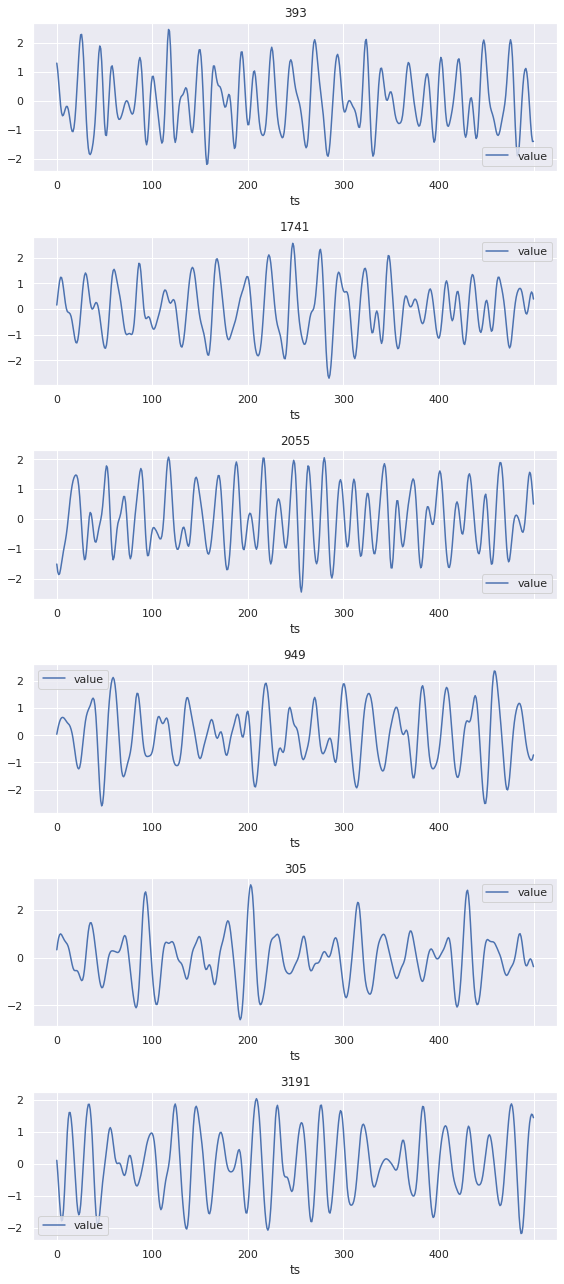

In [25]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_positive_idx):
    train_melt.loc[idx].plot(ax=axs[i])
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

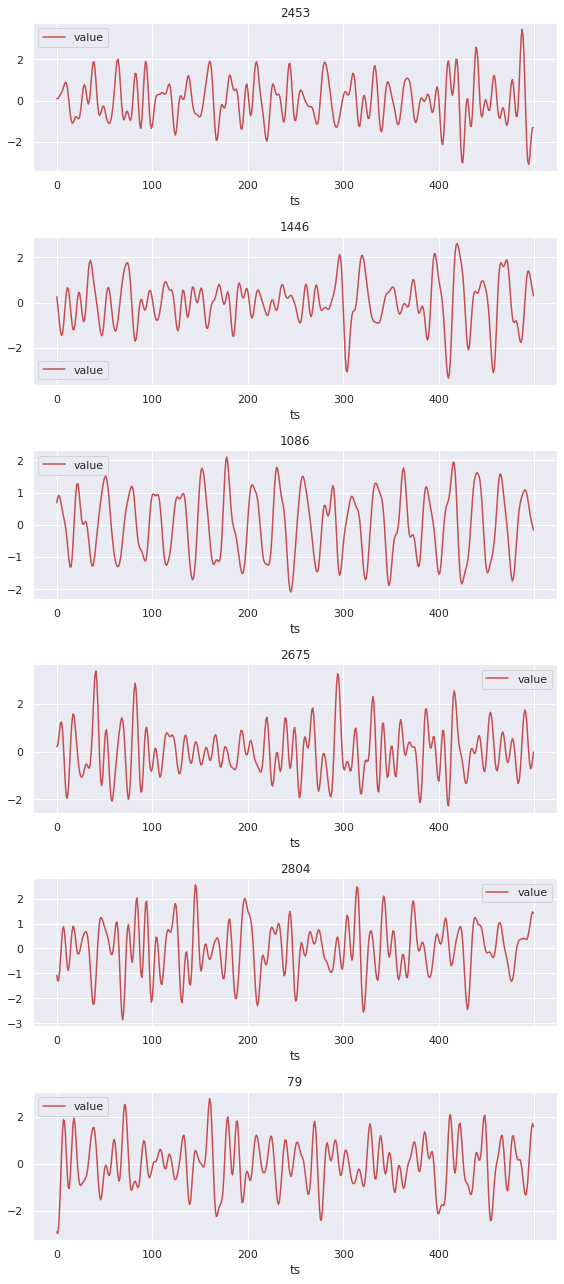

In [26]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_negative_idx):
    train_melt.loc[idx].plot(ax=axs[i], c='r')
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

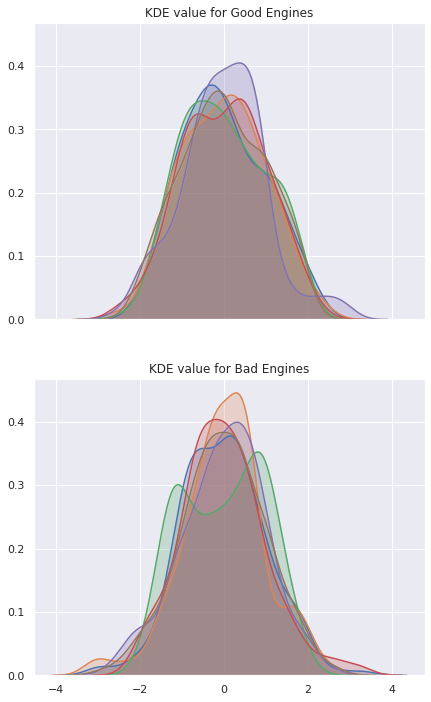

In [27]:
f, axs = plt.subplots(figsize=(7, 12), nrows=2,
                      sharex=True, sharey=True)
for idx in random_positive_idx:
    sns.distplot(train_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[0])
    axs[0].set_title('KDE value for Good Engines')

for idx in random_negative_idx:
    sns.distplot(train_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[1])
    axs[1].set_title('KDE value for Bad Engines')

plt.show()

**Obs**
- bad seems to be somewhat less normal => use normality test to separate?

# 1st approach: 

In [10]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.feature_extraction import extract_features

In [33]:
# ComprehensiveFCParameters()
# MinimalFCParameters()
EfficientFCParameters()

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'maximum': None,
 '

In [11]:
train_stacked = train_melt.reset_index()

In [ ]:
fc_parameters = {
    "skewness": None,
    "kurtosis": None,
    "fft_aggregated":[{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}]
}

In [12]:
extracted = extract_features(train_stacked, column_id='index',
                             column_sort='ts', default_fc_parameters=EfficientFCParameters(), n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [08:39<00:00, 25.98s/it]


In [36]:
extracted.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","value__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation,value__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
0,499.000001,201.612617,-0.005132,0.077591,0.123061,0.981790,-0.042278,-1.115422,0.506651,1.810807,...,1.0,-0.004518,-0.004283,-0.003233,0.0,0.0,0.0,0.998,0.0,-1.764393e+09
1,499.000000,173.350026,0.050234,0.117077,0.180290,1.307721,0.161383,-0.917663,0.647132,1.839293,...,1.0,0.006440,0.010403,-0.005324,0.0,0.0,0.0,0.998,0.0,-2.116525e+10
2,498.999998,188.742717,0.018044,0.056348,0.152620,1.213159,0.056659,-0.971904,0.459967,1.946056,...,1.0,-0.014969,-0.006315,-0.003683,0.0,0.0,0.0,0.998,0.0,-4.199983e+08
3,499.000001,187.211226,-0.001822,-0.024356,0.264462,1.020872,0.054905,-0.704142,0.380231,1.480024,...,1.0,0.011432,0.000562,0.001330,0.0,0.0,0.0,0.998,0.0,1.059632e+09
4,499.000001,246.460395,0.011495,0.033424,0.038234,1.169822,-0.101945,-1.839125,1.127160,2.166748,...,1.0,-0.033857,0.032445,0.123666,0.0,0.0,0.0,0.998,0.0,-2.385386e+09


In [38]:
extracted.isna().sum().sum()

0

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [17]:
logreg = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer

selector = SelectFromModel(estimator=ExtraTreesClassifier(n_jobs=-1), max_features=100).fit(extracted, train_y)

pl = make_pipeline(selector, PowerTransformer(), logreg)

In [32]:
scores = cross_val_score(pl, extracted.values, train_y.values, cv=10, scoring='f1')

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [33]:
np.mean(scores)

0.9997150997150998